In [1]:
import pandas as pd
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as patches

from matplotlib.dates import DateFormatter
from scipy.ndimage import gaussian_filter, zoom
from datetime import timedelta, datetime

billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)

billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week
billboard_hot_100.head()

C:\Users\cutie\AppData\Local\Temp\ipykernel_41324\523238995.py:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  billboard_hot_100["week"] = billboard_hot_100["first_day_of_the_week"].dt.week


,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year,week
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958,37
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958,37
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958,37
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958,37
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958,37


In [2]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

plt.rcParams.update({'font.size': 15})

In [19]:
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]
    
    songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & ~((billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"])))][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "year"]]
    grouped = songs_in_decade.groupby(["artist", "song_name"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year
                    })
                    week_date += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "year"]], pd.DataFrame(rows_to_add)], ignore_index=True)

In [20]:
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

In [21]:
test = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"] == "? (Question Mark) & The Mysterians") &\
        (billboard_100_with_empty_weeks["song_name"] == "96 Tears")]
test.to_csv("test.csv", index=False)

## Similarities between normalized trajectories for songs that reached top 1-10

In [5]:
def hamming_distance(s1, s2):
    return sum(ch1["position"] != ch2["position"] for ch1, ch2 in zip(s1, s2))

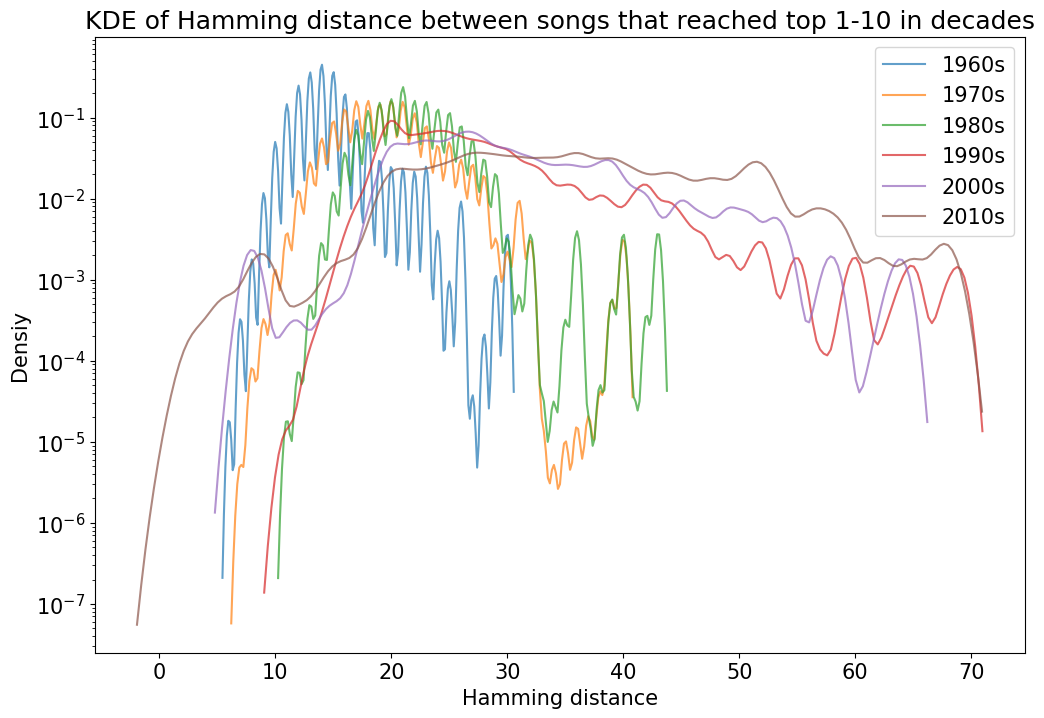

In [27]:
plt.figure(figsize=(12, 8))

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] < year) |\
        (billboard_100_with_empty_weeks["year"] >= year + 10)][["artist", "song_name"]]
    
    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 10)][["artist", "song_name"]]

    # take only songs from this decade
    top_10_positions_in_decade = top_10_positions_in_decade[~(top_10_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            top_10_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))]
    
    # take all positions of the songs
    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
        billboard_100_with_empty_weeks[["artist", "song_name",
            "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

    min_first_week  = top_10_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

    top_10_positions_in_decade["first_day_of_the_week"] = top_10_positions_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)
    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

    grouped = top_10_positions_in_decade.groupby(["artist", "song_name"])
    rows_to_compare = []
    for name, group in grouped:
        rows_to_compare.append([])
        for row_index, row in group.iterrows():
            rows_to_compare[-1].append({
                    "position": row["position"],
                })

    hamming_distances = []
    for row1 in rows_to_compare:
        for row2 in rows_to_compare:
            if row1 != row2:
                hamming_distances.append(hamming_distance(row1, row2))

    sns.kdeplot(hamming_distances, label=f'{year}s', alpha=0.7)

plt.xlabel("Hamming distance")
plt.ylabel("Densiy")
plt.yscale("log")
plt.title("KDE of Hamming distance between songs that reached top 1-10 in decades")
plt.legend()
plt.savefig("figures/top_1_10_trajectories_similarities_decades.pdf", format="pdf")
plt.show()

### For songs that never reached top 1-50

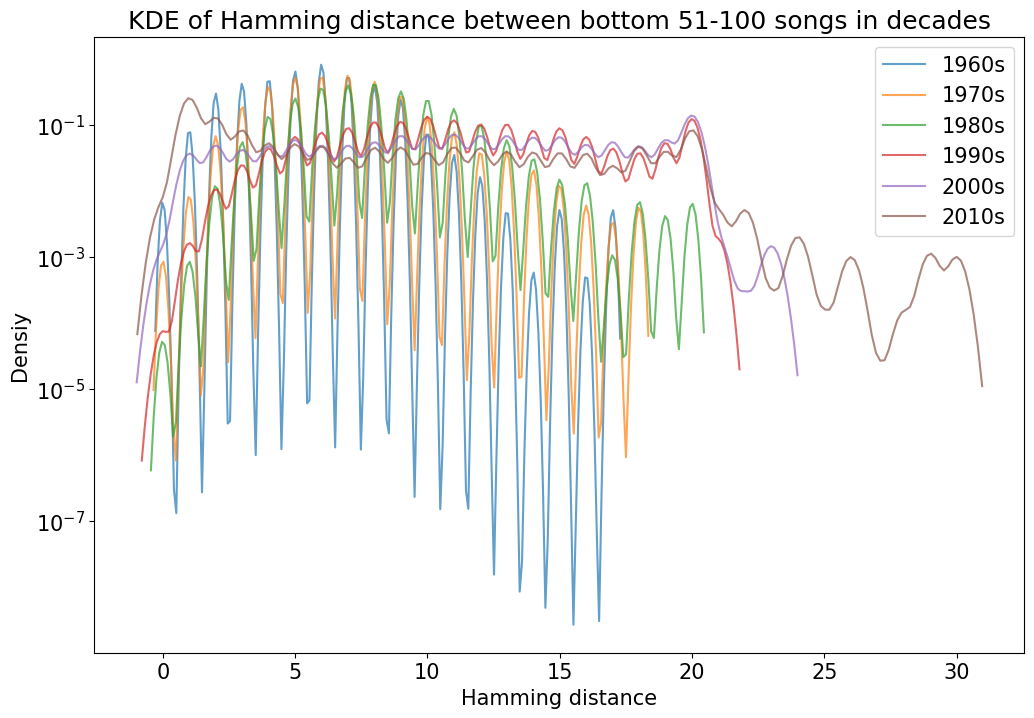

In [33]:
plt.figure(figsize=(12, 8))

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 50)][["artist", "song_name"]]

    # take songs only from this decade that have never been in top 10
    never_top_10_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"])) &\
                ~(all_songs_in_decade["artist"].isin(top_10_positions_in_decade["artist"]) &\
                    all_songs_in_decade["song_name"].isin(top_10_positions_in_decade["song_name"]))].copy()

    min_first_week  = never_top_10_in_decade["first_day_of_the_week"].min().to_pydatetime()

    never_top_10_in_decade["first_day_of_the_week"] = never_top_10_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)
    never_top_10_in_decade.set_index("first_day_of_the_week", inplace=True)

    grouped = never_top_10_in_decade.groupby(["artist", "song_name"])
    rows_to_compare = []
    for name, group in grouped:
        rows_to_compare.append([])
        for row_index, row in group.iterrows():
            rows_to_compare[-1].append({
                    "position": row["position"],
                })

    hamming_distances = []
    for row1 in rows_to_compare:
        for row2 in rows_to_compare:
            if row1 != row2:
                hamming_distances.append(hamming_distance(row1, row2))

    sns.kdeplot(hamming_distances, label=f'{year}s', alpha=0.7)

plt.xlabel("Hamming distance")
plt.ylabel("Densiy")
plt.yscale("log")
plt.title("KDE of Hamming distance between bottom 51-100 songs in decades")
plt.legend()
plt.savefig("figures/never_top_1_50_trajectories_similarities_decades.pdf", format="pdf")
plt.show()

### Using Manhattan distance

In [28]:
def manhattan_distance(s1, s2):
    return sum(abs(ch1["position"] - ch2["position"]) for ch1, ch2 in zip(s1, s2))

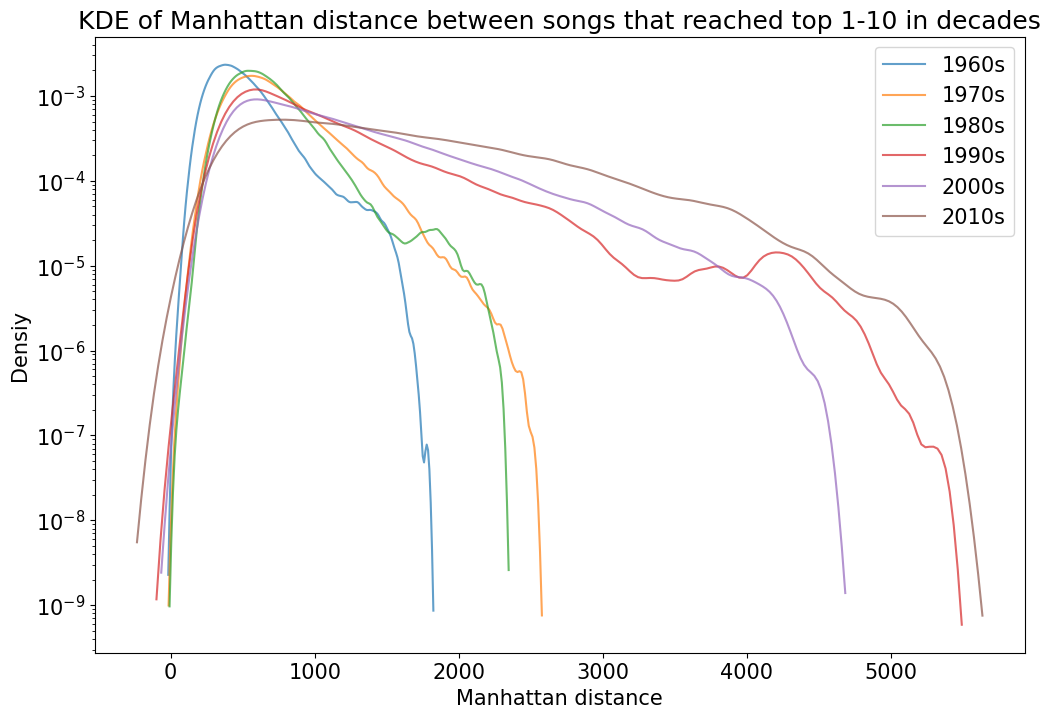

In [29]:
plt.figure(figsize=(12, 8))

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] < year) |\
        (billboard_100_with_empty_weeks["year"] >= year + 10)][["artist", "song_name"]]
    
    # take songs that appeared at least once at postion 1-10 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 10)][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "first_week"]]
                
    # take only songs from this decade
    top_10_positions_in_decade = top_10_positions_in_decade[~(top_10_positions_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            top_10_positions_in_decade["song_name"].isin(songs_from_other_decades["song_name"]))].sort_values(
        by="weeks_on_chart", ascending=False).reset_index()
    
    # take all positions of the songs
    top_10_positions_in_decade = top_10_positions_in_decade[["artist", "song_name"]].drop_duplicates().merge(
        billboard_100_with_empty_weeks[["artist", "song_name",
            "position", "first_day_of_the_week", "first_week"]], on=["artist", "song_name"], how="left")

    min_first_week  = top_10_positions_in_decade["first_day_of_the_week"].min().to_pydatetime()

    top_10_positions_in_decade["first_day_of_the_week"] = top_10_positions_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)
    top_10_positions_in_decade.set_index("first_day_of_the_week", inplace=True)

    grouped = top_10_positions_in_decade.groupby(["artist", "song_name"])
    rows_to_compare = []
    for name, group in grouped:
        rows_to_compare.append([])
        for row_index, row in group.iterrows():
            rows_to_compare[-1].append({
                    "position": row["position"],
                })

    manhattan_distances = []
    for row1 in rows_to_compare:
        for row2 in rows_to_compare:
            if row1 != row2:
                manhattan_distances.append(manhattan_distance(row1, row2))

    sns.kdeplot(manhattan_distances, label=f'{year}s', alpha=0.7)

plt.xlabel("Manhattan distance")
plt.ylabel("Densiy")
plt.yscale("log")
plt.title("KDE of Manhattan distance between songs that reached top 1-10 in decades")
plt.legend()
plt.savefig("figures/top_1_10_trajectories_similarities_decades_manhattan.pdf", format="pdf")
plt.show()

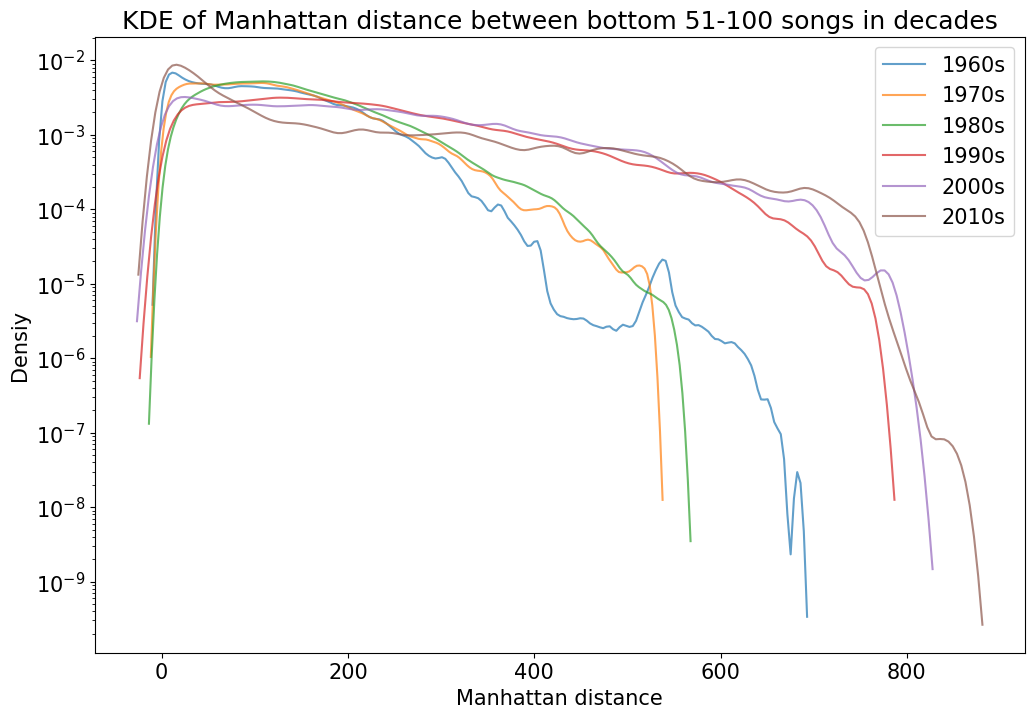

In [34]:
plt.figure(figsize=(12, 8))

for year in range(1960, 2020, 10):
    # all songs in the decade
    all_songs_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10)][["artist", "song_name", "first_day_of_the_week", "position",
            "first_week"]]

    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]

    # songs that reached top 50 in the decade
    top_10_positions_in_decade = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= year) &\
        (billboard_100_with_empty_weeks["year"] < year + 10) & (billboard_100_with_empty_weeks["position"] >= 1) &\
            (billboard_100_with_empty_weeks["position"] <= 50)][["artist", "song_name"]]

    # take songs only from this decade that have never been in top 10
    never_top_10_in_decade = all_songs_in_decade[~(all_songs_in_decade["artist"].isin(songs_from_other_decades["artist"]) &\
            all_songs_in_decade["song_name"].isin(songs_from_other_decades["song_name"])) &\
                ~(all_songs_in_decade["artist"].isin(top_10_positions_in_decade["artist"]) &\
                    all_songs_in_decade["song_name"].isin(top_10_positions_in_decade["song_name"]))].copy()

    min_first_week  = never_top_10_in_decade["first_day_of_the_week"].min().to_pydatetime()

    never_top_10_in_decade["first_day_of_the_week"] = never_top_10_in_decade.apply(lambda row:
        int(((min_first_week + timedelta(days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)
    never_top_10_in_decade.set_index("first_day_of_the_week", inplace=True)

    grouped = never_top_10_in_decade.groupby(["artist", "song_name"])
    rows_to_compare = []
    for name, group in grouped:
        rows_to_compare.append([])
        for row_index, row in group.iterrows():
            rows_to_compare[-1].append({
                    "position": row["position"],
                })

    manhattan_distances = []
    for row1 in rows_to_compare:
        for row2 in rows_to_compare:
            if row1 != row2:
                manhattan_distances.append(manhattan_distance(row1, row2))

    sns.kdeplot(manhattan_distances, label=f'{year}s', alpha=0.7)

plt.xlabel("Manhattan distance")
plt.ylabel("Densiy")
plt.yscale("log")
plt.title("KDE of Manhattan distance between bottom 51-100 songs in decades")
plt.legend()
plt.savefig("figures/never_top_1_50_trajectories_similarities_decades_manhattan.pdf", format="pdf")
plt.show()